# Differential Gene Expression Analysis with scRNA-seq Data
### Eric Pham, Maahi Shah, Ben Deviney
### DSC 190
### 12/7/2024

This is a notebook that conducts a differential gene analysis based on clusters 
formed by a principal components analysis. From this we can generate lists of 
genes that are differentially expressed in treated and untreated cells.

##### Loading in scRNA-seq Data

First we need to read in and preprocess all of the data.

In [1]:
'''Import Statements'''

import scanpy as sc
import anndata as ad

In [2]:
'''Read in scRNA-seq Data'''

# Reads in sparse matrix format data using scanpy. Result is AnnData object.
adata_untreated = sc.read_10x_mtx("GSM3290893_CountTable_HBCx-95_scRNA/filtered_gene_bc_matrices_HBCx-95/hg19/")
adata_treated = sc.read_10x_mtx("GSM3290894_CountTable_HBCx-95-CapaR_scRNA/filtered_gene_bc_matrices_HBCx-95_CAPAR/hg19/")

# Label samples treated with capecitabine and not treated (control).
adata_treated.obs["condition"] = "treated"
adata_untreated.obs["condition"] = "untreated"

In [3]:
'''Quality Control Step'''

# Remove all cells with less than 200 gene read and all genes with less than 3 
# cells.
sc.pp.filter_cells(adata_treated, min_genes=200)
sc.pp.filter_cells(adata_untreated, min_genes=200)
sc.pp.filter_genes(adata_treated, min_cells=3)
sc.pp.filter_genes(adata_untreated, min_cells=3)

# Normalize both datasets, and take log1p transformation to ensure non-negative
# values.
sc.pp.normalize_total(adata_treated, target_sum=1e4)
sc.pp.log1p(adata_treated)

sc.pp.normalize_total(adata_untreated, target_sum=1e4)
sc.pp.log1p(adata_untreated)

# Combine the datasets.
adata_combined = ad.concat([adata_treated, adata_untreated], merge="same")

##### PCA, Clustering, & Visualization

With the cleaned dataset, we can now perform our analysis to generate groups of 
differentially expressed genes.

Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "numpy\\random\\mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.randint
  File "numpy\\random\\_bounded_integers.pyx", line 1423, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32
Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "numpy\\random\\mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.randint
  File "numpy\\random\\_bounded_integers.pyx", line 1423, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32
Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "numpy\\random\\mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.randint
  File "numpy\\random\\_bounded_integers.pyx", line 1423, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32
Exception ignored in: <class 'ValueError'>
Traceback (m

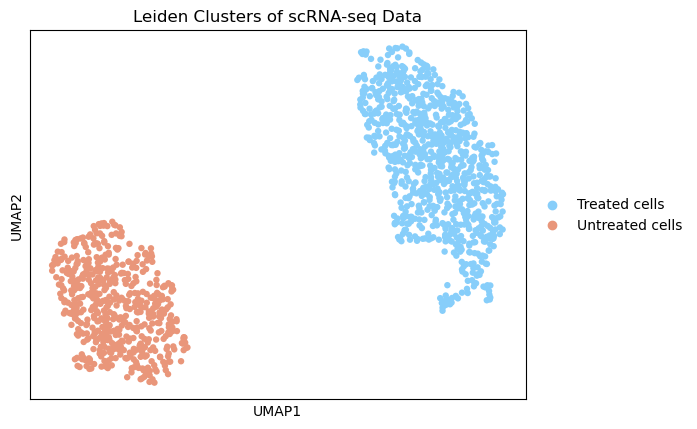

In [4]:
'''PCA and Clustering'''

# Perform PCA.
sc.tl.pca(adata_combined, svd_solver="arpack")

# Compute nearest neighbors and cluster cells.
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_combined, resolution=0.1, flavor="igraph", n_iterations=2)

# Annotate clusters by condition.
adata_combined.obs["condition"] = adata_combined.obs["leiden"].replace({
    "0": "Treated cells",
    "1": "Untreated cells",
})

# Visualize using UMAP.
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, 
           color=["condition"],
           palette=['lightskyblue', 'darksalmon'],
           title='Leiden Clusters of scRNA-seq Data')

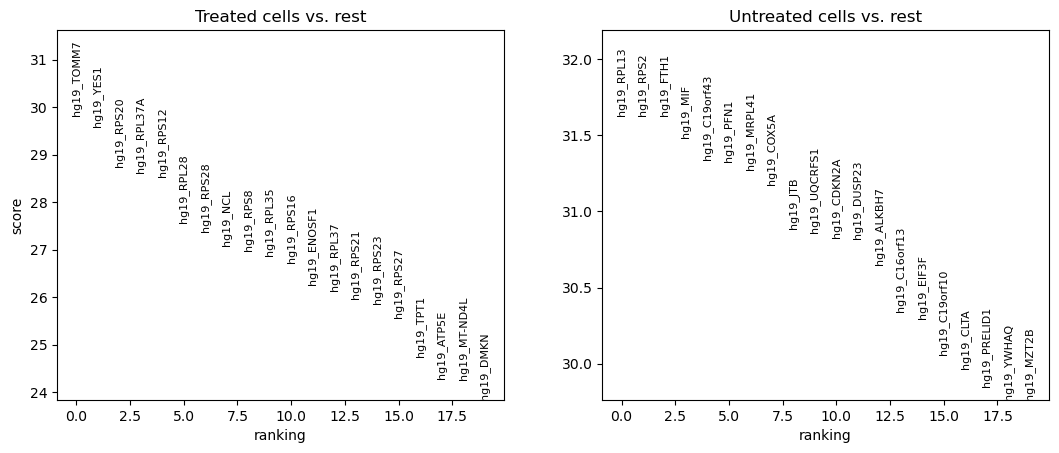

In [5]:
'''Differential Gene Expression Analysis'''

# Top ranked gene groups for each condition.
sc.tl.rank_genes_groups(adata_combined, groupby="condition", method="wilcoxon")

# Visualization of top differential genes.
sc.pl.rank_genes_groups(adata_combined, n_genes=20, sharey=False)

In [6]:
'''List of Significant Genes'''

# Corrected p-value cut off.
thresh = 0.05 / adata_combined.shape[1]
significant_genes = sc.get.rank_genes_groups_df(adata_combined, group=None, pval_cutoff=thresh)

significant_genes['names'] = significant_genes['names'].apply(lambda x: x.strip("hg_19"))

# significant_genes.to_csv("dge_scRNA_seq_genes.csv")
significant_genes

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,Treated cells,TOMM7,29.828402,1.250383,1.673589e-195,1.280031e-192
1,Treated cells,YES,29.598537,3.743009,1.560406e-192,9.859054e-190
2,Treated cells,RPS20,28.743666,0.924485,1.086902e-181,4.387459e-179
3,Treated cells,RPL37A,28.629206,0.855751,2.910015e-180,1.142928e-177
4,Treated cells,RPS12,28.539419,0.986028,3.800882e-179,1.453537e-176
...,...,...,...,...,...,...
7919,Untreated cells,RPS12,-28.539419,-0.986028,3.800882e-179,1.453537e-176
7920,Untreated cells,RPL37A,-28.629206,-0.855751,2.910015e-180,1.142928e-177
7921,Untreated cells,RPS20,-28.743666,-0.924485,1.086902e-181,4.387459e-179
7922,Untreated cells,YES,-29.598537,-3.743009,1.560406e-192,9.859054e-190
